# Aircraft Classification with PyTorch(Agentic AI)

## Imports Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Load Dataset

Annotations preview:
                           filename  width  height class  xmin  ymin  xmax  \
0  0000e97ea2d086d6759b19b288a8a72c   4928    3264  Mi28  1380  1904  1522   
1  0000e97ea2d086d6759b19b288a8a72c   4928    3264  Mi28  1809  1625  1958   
2  0000e97ea2d086d6759b19b288a8a72c   4928    3264  Mi28  2400  1571  2532   
3  0000e97ea2d086d6759b19b288a8a72c   4928    3264  Mi28  3935  1772  4100   

   ymax  
0  2014  
1  1759  
2  1727  
3  1891  


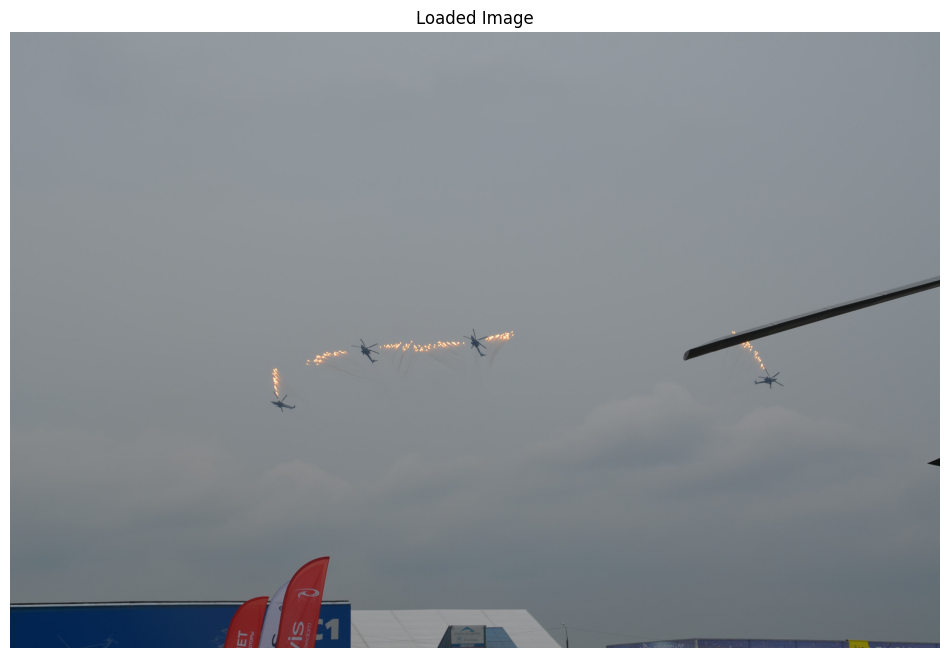

In [2]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Base path
base_path = '/kaggle/input/militaryaircraftdetectiondataset/'

# Load image
image_filename = '0000e97ea2d086d6759b19b288a8a72c.jpg'
image_path = os.path.join(base_path, 'dataset', image_filename)
img = Image.open(image_path)

# Load annotations CSV
csv_filename = image_filename.replace('.jpg', '.csv')
csv_path = os.path.join(base_path, 'dataset', csv_filename)
df = pd.read_csv(csv_path)

# Print annotation preview
print("Annotations preview:")
print(df.head())

# Display image using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title('Loaded Image')
plt.show()


## Visualization

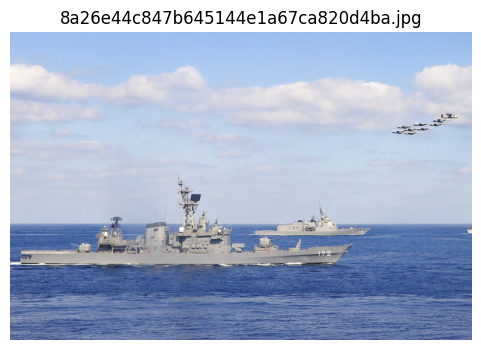

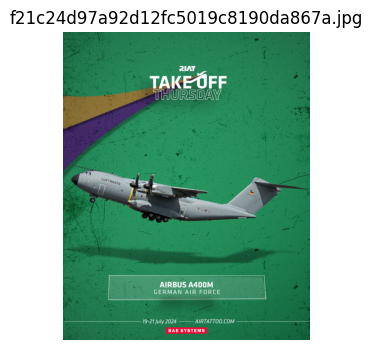

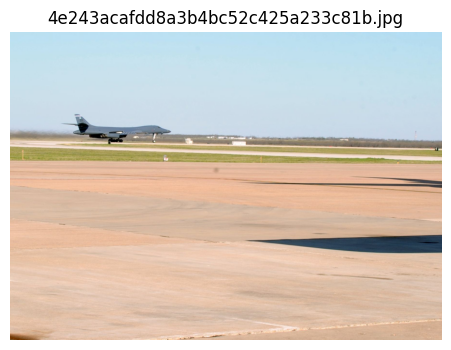

In [3]:
import os
import cv2
import random
import matplotlib.pyplot as plt
from glob import glob

# Path to image folder
image_dir = '/kaggle/input/militaryaircraftdetectiondataset/dataset'

# Get all image file paths
all_images = glob(os.path.join(image_dir, '*.jpg'))

# Randomly select 3 images
sample_imgs = random.sample(all_images, 3)

# Display each image
for img_path in sample_imgs:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct colors
    plt.figure(figsize=(6, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(img_path))
    plt.show()

## Custom Dataset Class

In [4]:
class AircraftDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = 1 if 'military' in img_path.lower() else 0

        if self.transform:
            image = self.transform(image)

        return image, label

## Data Transforms and Loaders

In [5]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

from sklearn.model_selection import train_test_split

train_paths, test_paths = train_test_split(all_images, test_size=0.2, random_state=42)

train_dataset = AircraftDataset(train_paths, transform=transform)
test_dataset = AircraftDataset(test_paths, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## CNN Model Architecture

In [6]:
class AircraftCNN(nn.Module):
    def __init__(self):
        super(AircraftCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 16, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 32, 32, 32]
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training Loop

In [7]:
import time

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model and move it to the selected device
model = AircraftCNN().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs for training
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    start_time = time.time()

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # shape: [B, 2]

        # Ensure labels are integers: 0 or 1
        if labels.dtype != torch.long:
            labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    duration = time.time() - start_time
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Time: {duration:.2f}s")

Using device: cuda


Epoch 1/5: 100%|██████████| 525/525 [14:20<00:00,  1.64s/it]


Epoch [1/5] - Loss: 0.0013, Accuracy: 100.00%, Time: 860.33s


Epoch 2/5: 100%|██████████| 525/525 [11:45<00:00,  1.34s/it]


Epoch [2/5] - Loss: 0.0000, Accuracy: 100.00%, Time: 705.98s


Epoch 3/5: 100%|██████████| 525/525 [11:49<00:00,  1.35s/it]


Epoch [3/5] - Loss: 0.0000, Accuracy: 100.00%, Time: 709.66s


Epoch 4/5: 100%|██████████| 525/525 [11:56<00:00,  1.36s/it]


Epoch [4/5] - Loss: 0.0000, Accuracy: 100.00%, Time: 716.03s


Epoch 5/5: 100%|██████████| 525/525 [11:57<00:00,  1.37s/it]

Epoch [5/5] - Loss: 0.0000, Accuracy: 100.00%, Time: 717.27s


## Evaluation

In [8]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Accuracy on the test set: {test_accuracy:.2f}%")

Accuracy on the test set: 100.00%


## Agentic Decision Function

In [9]:
def agentic_decision_system(img_path, model):
    model.eval()
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    input_tensor = transform(image).unsqueeze(0).to(device)
    output = model(input_tensor)
    _, prediction = torch.max(output, 1)

    if prediction.item() == 1:
        return "ALERT: Military Aircraft Detected"
    else:
        return "No Threat: Civil Aircraft"

## Agentic Test on Random Image

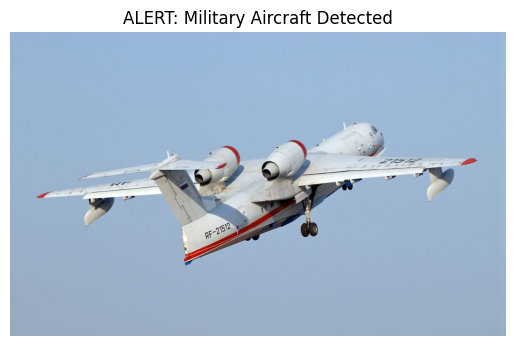

In [10]:
test_img = random.choice(test_paths)
decision = agentic_decision_system(test_img, model)

img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.title(decision)
plt.show()

## Summary
This project implements an Agentic AI system using a Convolutional Neural Network (CNN) to detect and classify military aircraft from aerial images. Trained on the Military Aircraft Detection Dataset with PyTorch, the model distinguishes between military and civilian aircraft and triggers automated alerts when a military aircraft is detected. The entire system runs seamlessly on Kaggle with GPU support, simulating real-time decision-making for autonomous aerial surveillance.